 ## Tutorial: Build an Extractive QA Pipeline

- **Level**: Beginner
- **Time to complete**: 15 minutes
- **Components Used**: [`ExtractiveReader`](https://docs.haystack.deepset.ai/v2.0/docs/extractivereader), [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/v2.0/docs/inmemorydocumentstore), [`InMemoryEmbeddingRetriever`](https://docs.haystack.deepset.ai/v2.0/docs/inmemoryembeddingretriever), [`DocumentWriter`](https://docs.haystack.deepset.ai/v2.0/docs/documentwriter), [`SentenceTransformersDocumentEmbedder`](https://docs.haystack.deepset.ai/v2.0/docs/sentencetransformersdocumentembedder), [`SentenceTransformersTextEmbedder`](https://docs.haystack.deepset.ai/v2.0/docs/sentencetransformerstextembedder)
- **Goal**: After completing this tutorial, you'll have learned how to build a Haystack pipeline that uses an extractive model to display where the answer to your query is.

> This tutorial uses Haystack 2.0. To learn more, read the [Haystack 2.0 announcement](https://haystack.deepset.ai/blog/haystack-2-release) or visit the [Haystack 2.0 Documentation](https://docs.haystack.deepset.ai/docs/intro).



## Overview

What is extractive question answering? So glad you asked! The short answer is that extractive models pull verbatim answers out of text. It's good for use cases where accuracy is paramount, and you need to know exactly where in the text that the answer came from. If you want additional context, here's [a deep dive on extractive versus generative language models](https://haystack.deepset.ai/blog/generative-vs-extractive-models).

In this tutorial you'll create a Haystack pipeline that extracts answers to questions, based on the provided documents.

To get data into the extractive pipeline, you'll also build an indexing pipeline to ingest the [Wikipedia pages of Seven Wonders of the Ancient World dataset](https://en.wikipedia.org/wiki/Wonders_of_the_World).

## Preparing the Colab Environment

- [Enable GPU Runtime in Colab](https://docs.haystack.deepset.ai/v2.0/docs/enabling-gpu-acceleration)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/v2.0/docs/logging)

#Installation


In [1]:
!pip install haystack-ai accelerate sentence-transformers

  Using cached haystack_ai-2.0.0-py3-none-any.whl.metadata (12 kB)
  Using cached sentence_transformers-2.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached boilerpy3-1.0.7-py3-none-any.whl.metadata (5.8 kB)
  Using cached haystack_bm25-1.0.2-py2.py3-none-any.whl.metadata (3.9 kB)
  Using cached lazy_imports-0.3.1-py3-none-any.whl.metadata (10 kB)
  Using cached more_itertools-10.2.0-py3-none-any.whl.metadata (34 kB)
  Using cached posthog-3.5.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached monotonic-1.6-py2.py3-none-any.whl.metadata (1.5 kB)
  Using cached backoff-2.2.1-py3-none-any.whl.metadata (14 kB)
Using cached haystack_ai-2.0.0-py3-none-any.whl (265 kB)
Using cached sentence_transformers-2.6.1-py3-none-any.whl (163 kB)
   ---------------------------------------- 0.0/266.9 kB ? eta -:--:--
   ---------------- ----------------------- 112.6/266.9 kB 2.2 MB/s eta 0:00:01
   -------------------------------------

In [ ]:
pip install 'sentence-transformers>=2.2.0'


  Using cached sentence_transformers-2.6.1-py3-none-any.whl (163 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.8 MB/s eta 0:00:00
     ━━━━

Knowing you’re using this tutorial helps us decide where to invest our efforts to build a better product but you can always opt out by commenting the following line. See [Telemetry](https://docs.haystack.deepset.ai/v2.0/docs/enabling-telemetry) for more details.

In [ ]:
pip 

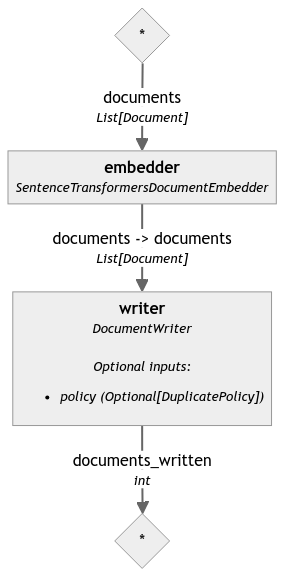

In [11]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter

model = "sentence-transformers/multi-qa-mpnet-base-dot-v1"

document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()

indexing_pipeline.add_component(instance=SentenceTransformersDocumentEmbedder(model=model), name="embedder")
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="writer")
indexing_pipeline.connect("embedder.documents", "writer.documents")

NER IMPLEMENTATION

In [16]:
import requests
from haystack import Document
import spacy


documents = []

# Load the NER model
nlp = spacy.load("custom_ner_model_with_bert")

# Function to fetch book data from Google Books API
def fetch_book_data(book_title):
    api_url = f"https://www.googleapis.com/books/v1/volumes?q={book_title}&maxResults=1&langRestrict=en&printType=books"
    response = requests.get(api_url)
    if response.status_code == 200:
        book_data = response.json()
        if "items" in book_data:
            return book_data["items"]
    return None

# Function to extract book title from user input using NER
def extract_book_title(question):
    entities = nlp(question)
    for ent in entities.ents:  # Iterate over recognized entities
        if ent.label_ == 'BOOK_TITLE':  # Check if the entity is a book title
            return ent.text
    return None

# Prompt user for a question about a book
user_question = input("Ask a question about a book: ")

# Extract book title from user input
book_title = extract_book_title(user_question)
book_items = fetch_book_data(book_title)

if book_items:
        # Create Document objects for each book item and aggregate descriptions
        descriptions = []  # List to aggregate descriptions from all items
        for item in book_items:
            meta = item.get("volumeInfo", {})

            # Ensure all keys are present and set their value to "Not available" if missing
            all_keys = ['subtitle', 'authors', 'publisher', 'publishedDate',
                        'industryIdentifiers', 'readingModes', 'pageCount', 'printType', 'categories',
                        'averageRating', 'ratingsCount', 'maturityRating', 'allowAnonLogging',
                        'contentVersion', 'panelizationSummary', 'imageLinks', 'language',
                        'previewLink', 'infoLink', 'canonicalVolumeLink', 'seriesInfo']
            for key in all_keys:
                if key not in meta:
                    meta[key] = "Not available"
                elif isinstance(meta[key], list):
                    # Convert each item in the list to string
                    meta[key] = ", ".join(str(item) for item in meta[key])

            # Create content with title and description
            content = f"Title: {meta.get('title', 'Not available')}\n"
            content += f"Description: {meta.get('description', 'Not available')}\n"
            content += f"Number of pages: {meta.get('pageCount', 'Not available')}"

            # Remove title and description from meta
            meta.pop('description', None)

            document = Document(content=content, meta=meta)
            documents.append(document)
else:
    print("Book data not found.")


In [17]:
print(book_title)

educated


In [18]:
indexing_pipeline.run({"documents": documents})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'writer': {'documents_written': 1}}

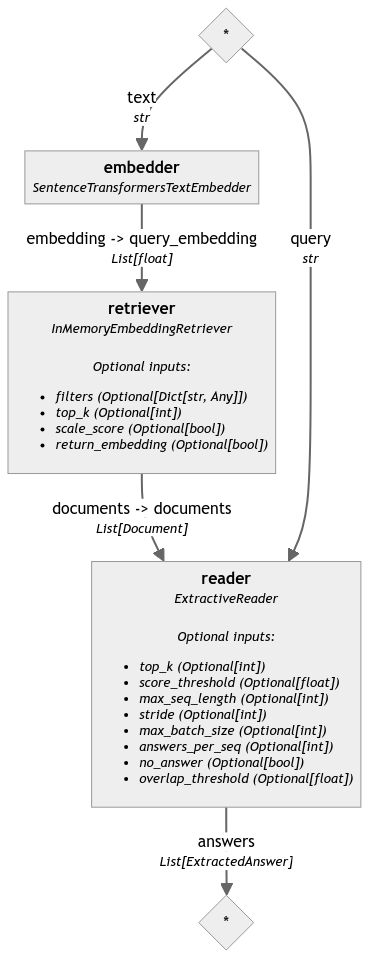

In [19]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder


retriever = InMemoryEmbeddingRetriever(document_store=document_store)
reader = ExtractiveReader(model='deepset/roberta-base-squad2')
reader.warm_up()

extractive_qa_pipeline = Pipeline()

extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")

In [20]:
response = extractive_qa_pipeline.run(
    data={"embedder": {"text": user_question}, "retriever": {"top_k": 3}, "reader": {"query": user_question, "top_k": 1}}
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
response

{'reader': {'answers': [ExtractedAnswer(query='what is educated about?', score=0.5995774269104004, data='ignorance', document=Document(id=83d6430675c823ccc37abc1695f0f0766f19177971074c7aed74820b608a297c, content: 'Title: The Educated Franchisee
   Description: There is nothing more expensive than ignorance – let The...', meta: {'title': 'The Educated Franchisee', 'subtitle': 'The How-to Book for Choosing a Winning Franchise', 'authors': 'Rick Bisio, Mike Kohler', 'publisher': 'Hillcrest Publishing Group', 'publishedDate': '2011', 'industryIdentifiers': "{'type': 'ISBN_13', 'identifier': '9781935098539'}, {'type': 'ISBN_10', 'identifier': '1935098535'}", 'readingModes': {'text': False, 'image': True}, 'pageCount': 219, 'printType': 'BOOK', 'categories': 'Business & Economics', 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': False, 'contentVersion': '0.1.1.0.preview.1', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnai

In [22]:
answers = response['reader']['answers']

# Filter out answers with None data
valid_answers = [answer for answer in answers if answer.data is not None]

# Find the answer with the highest score among valid answers
best_answer = max(valid_answers, key=lambda x: x.score)

print("Best Answer:", best_answer.data)

Best Answer: ignorance


In [2]:
%pip install gradio

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.



  Using cached gradio-4.25.0-py3-none-any.whl.metadata (15 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached fastapi-0.110.1-py3-none-any.whl.metadata (24 kB)
  Using cached ffmpy-0.3.2.tar.gz (5.5 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached gradio_client-0.15.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     ---------------------------------------- 50.7/50.7 kB 2.5 MB/s eta 0:00:00
     ----------------------

In [1]:
import gradio as gr
import os
import time
from bookworm_ai import setup_indexing_pipeline, fetch_book_data, extract_book_title, create_document_objects, setup_qa_pipeline, get_best_answer
import spacy

# Chatbot demo with multimodal input (text, markdown, LaTeX, code blocks, image, audio, & video). Plus shows support for streaming text.


def print_like_dislike(x: gr.LikeData):
    print(x.index, x.value, x.liked)
    
def main(user_question):
    
    # Setup indexing pipeline
    indexing_pipeline, document_store = setup_indexing_pipeline()

    # Load the NER model
    nlp = spacy.load("custom_ner_model_with_bert")

    # Extract book title from user input
    book_title = extract_book_title(user_question, nlp)
    print("book title is", book_title)

    book_items = fetch_book_data(book_title)
    # Create document objects for each book item and aggregate descriptions
    documents = create_document_objects(book_items)

    if documents:
        indexing_pipeline.run({"documents": documents})
    else:
        print("Book data not found.")

    # Setup QA pipeline
    qa_pipeline = setup_qa_pipeline(document_store)

    # Get best answer
    best_answer = get_best_answer(qa_pipeline, user_question)

    return(best_answer.data)
    
def add_message(history, message):
    for x in message["files"]:
        history.append(((x,), None))
    if message["text"] is not None:
        history.append((message["text"], None))
    return history, gr.MultimodalTextbox(value=None, interactive=False)

def bot(history):
    user_input = history[-1][0]
    response = main(user_input)
    history[-1][1] = ""
    for character in response:
        history[-1][1] += character
        time.sleep(0.05)
        yield history


with gr.Blocks() as demo:
    chatbot = gr.Chatbot(
        [],
        elem_id="chatbot",
        bubble_full_width=False,
    )

    chat_input = gr.MultimodalTextbox(interactive=True, file_types=["image"], placeholder="Enter message or upload file...", show_label=False)

    chat_msg = chat_input.submit(add_message, [chatbot, chat_input], [chatbot, chat_input])
    bot_msg = chat_msg.then(bot, chatbot, chatbot, api_name="bot_response")
    bot_msg.then(lambda: gr.MultimodalTextbox(interactive=True), None, [chat_input])

    chatbot.like(print_like_dislike, None, None)

demo.queue()
demo.launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


book title is a man called ove
[Document(id=73ee1afaee1033ab05df44d037e7db9e5358bf8e6b25eb5d0b98a339eb2e7ff2, content: 'Title: A Man Called Ove
Genre , Category: Fiction
Description , What the book is about: Now a major ...', meta: {'title': 'A Man Called Ove', 'subtitle': 'A Novel', 'authors': 'Fredrik Backman', 'publisher': 'Simon and Schuster', 'publishedDate': '2014-07-15', 'industryIdentifiers': "{'type': 'ISBN_13', 'identifier': '9781476738031'}, {'type': 'ISBN_10', 'identifier': '1476738033'}", 'readingModes': {'text': True, 'image': False}, 'pageCount': 368, 'printType': 'BOOK', 'categories': 'Fiction', 'averageRating': 5, 'ratingsCount': 2, 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': True, 'contentVersion': '1.68.54.0.preview.2', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=7mtNAgAAQBAJ&printsec=frontcover&img=1&zoom=5&edge=curl&source=gbs_api', 'thumbnai

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

book title is thinking fast and slow
[Document(id=7fd9184f1111fc319b690434c8049726f44ff0ee2495c72643b384e67fe2057d, content: 'Title: Thinking, Fast and Slow
Genre , Category: Psychology
Description , What the book is about: Ma...', meta: {'title': 'Thinking, Fast and Slow', 'authors': 'Daniel Kahneman', 'publisher': 'Farrar, Straus and Giroux', 'publishedDate': '2011-10-25', 'industryIdentifiers': "{'type': 'ISBN_13', 'identifier': '9781429969352'}, {'type': 'ISBN_10', 'identifier': '1429969350'}", 'readingModes': {'text': True, 'image': False}, 'pageCount': 511, 'printType': 'BOOK', 'categories': 'Psychology', 'averageRating': 4, 'ratingsCount': 36, 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': True, 'contentVersion': '6.39.31.0.preview.2', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=ZuKTvERuPG8C&printsec=frontcover&img=1&zoom=5&edge=curl&source=gbs_api', 'thumbna

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

book title is to kill a mockingbird
[Document(id=c768cfa5904c1bb1aa1ced8d27bedd9c2d58a776f3e238d5fe046ad53cb2a215, content: 'Title: To Kill a Mockingbird
Genre , Category: Fiction
Description , What the book is about: A novel...', meta: {'title': 'To Kill a Mockingbird', 'authors': 'Harper Lee', 'publisher': 'Random House', 'publishedDate': '2010', 'industryIdentifiers': "{'type': 'ISBN_13', 'identifier': '9780099549482'}, {'type': 'ISBN_10', 'identifier': '0099549484'}", 'readingModes': {'text': False, 'image': False}, 'pageCount': 322, 'printType': 'BOOK', 'categories': 'Fiction', 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': False, 'contentVersion': '0.2.0.0.preview.0', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=st6EqikLVKoC&printsec=frontcover&img=1&zoom=5&source=gbs_api', 'thumbnail': 'http://books.google.com/books/content?id=st6EqikLVKoC&printsec=frontcover&

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

book title is thinking fast and slow
[Document(id=7fd9184f1111fc319b690434c8049726f44ff0ee2495c72643b384e67fe2057d, content: 'Title: Thinking, Fast and Slow
Genre , Category: Psychology
Description , What the book is about: Ma...', meta: {'title': 'Thinking, Fast and Slow', 'authors': 'Daniel Kahneman', 'publisher': 'Farrar, Straus and Giroux', 'publishedDate': '2011-10-25', 'industryIdentifiers': "{'type': 'ISBN_13', 'identifier': '9781429969352'}, {'type': 'ISBN_10', 'identifier': '1429969350'}", 'readingModes': {'text': True, 'image': False}, 'pageCount': 511, 'printType': 'BOOK', 'categories': 'Psychology', 'averageRating': 4, 'ratingsCount': 36, 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': True, 'contentVersion': '6.39.31.0.preview.2', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=ZuKTvERuPG8C&printsec=frontcover&img=1&zoom=5&edge=curl&source=gbs_api', 'thumbna

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

book title is it ends with us
[Document(id=e5165b40d2214d4ee183482aa8784e149f973a63db480b3981062a5d2fb986f9, content: 'Title: It Ends With Us (versione italiana)
Genre , Category: Fiction
Description , What the book is ...', meta: {'title': 'It Ends With Us (versione italiana)', 'authors': 'Colleen Hoover', 'publisher': 'SPERLING & KUPFER', 'publishedDate': '2022-03-01', 'industryIdentifiers': "{'type': 'ISBN_13', 'identifier': '9788892742444'}, {'type': 'ISBN_10', 'identifier': '8892742442'}", 'readingModes': {'text': True, 'image': True}, 'pageCount': 298, 'printType': 'BOOK', 'categories': 'Fiction', 'averageRating': 3.5, 'ratingsCount': 4, 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': True, 'contentVersion': '1.3.3.0.preview.3', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=rmdcEAAAQBAJ&printsec=frontcover&img=1&zoom=5&edge=curl&source=gbs_api', 'thumbnail': 'htt

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack import Document
import requests
import spacy


def setup_indexing_pipeline(model="sentence-transformers/multi-qa-mpnet-base-dot-v1"):
    document_store = InMemoryDocumentStore()

    indexing_pipeline = Pipeline()

    indexing_pipeline.add_component(instance=SentenceTransformersDocumentEmbedder(model=model), name="embedder")
    indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="writer")
    indexing_pipeline.connect("embedder.documents", "writer.documents")

    return indexing_pipeline, document_store


def fetch_book_data(book_title):
    api_url = f"https://www.googleapis.com/books/v1/volumes?q={book_title}&maxResults=1&langRestrict=en&printType=books"
    response = requests.get(api_url)
    if response.status_code == 200:
        book_data = response.json()
        if "items" in book_data:
            return book_data["items"]
    return None


def extract_book_title(question, ner_model):
    entities = ner_model(question)
    for ent in entities.ents:  # Iterate over recognized entities
        if ent.label_ == 'BOOK_TITLE':  # Check if the entity is a book title
            return ent.text
    return None


def create_document_objects(book_items):
    documents = []
    if book_items:
        for item in book_items:
            meta = item.get("volumeInfo", {})

            # Ensure all keys are present and set their value to "Not available" if missing
            all_keys = ['subtitle', 'authors', 'publisher', 'publishedDate',
                        'industryIdentifiers', 'readingModes', 'pageCount', 'printType', 'categories',
                        'averageRating', 'ratingsCount', 'maturityRating', 'allowAnonLogging',
                        'contentVersion', 'panelizationSummary', 'imageLinks', 'language',
                        'previewLink', 'infoLink', 'canonicalVolumeLink', 'seriesInfo']
            for key in all_keys:
                if key not in meta:
                    meta[key] = "Not available"
                elif isinstance(meta[key], list):
                    # Convert each item in the list to string
                    meta[key] = ", ".join(str(item) for item in meta[key])

            # Create content with title and description
            content = f"Title: {meta.get('title', 'Not available')}\n"
            content += f"Description: {meta.get('description', 'Not available')}\n"
            content += f"Number of pages: {meta.get('pageCount', 'Not available')}"

            # Remove title and description from meta
            meta.pop('description', None)

            document = Document(content=content, meta=meta)
            documents.append(document)
    return documents


def setup_qa_pipeline(document_store, model='sentence-transformers/multi-qa-mpnet-base-dot-v1'):
    retriever = InMemoryEmbeddingRetriever(document_store=document_store)
    reader = ExtractiveReader(model='deepset/roberta-base-squad2')
    reader.warm_up()

    extractive_qa_pipeline = Pipeline()

    extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
    extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
    extractive_qa_pipeline.add_component(instance=reader, name="reader")

    extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
    extractive_qa_pipeline.connect("retriever.documents", "reader.documents")

    return extractive_qa_pipeline


def get_best_answer(qa_pipeline, user_question):
    response = qa_pipeline.run(
        data={"embedder": {"text": user_question}, "retriever": {"top_k": 3},
              "reader": {"query": user_question, "top_k": 1}}
    )

    answers = response['reader']['answers']

    # Filter out answers with None data
    valid_answers = [answer for answer in answers if answer.data is not None]

    # Find the answer with the highest score among valid answers
    best_answer = max(valid_answers, key=lambda x: x.score)

    return best_answer


def main():
    
    # Setup indexing pipeline
    indexing_pipeline, document_store = setup_indexing_pipeline()

    # Load the NER model
    nlp = spacy.load("custom_ner_model_with_bert")

    # Prompt user for a question about a book
    user_question = input("Ask a question about a book: ")

    # Extract book title from user input
    book_title = extract_book_title(user_question, nlp)
    book_items = fetch_book_data(book_title)

    # Create document objects for each book item and aggregate descriptions
    documents = create_document_objects(book_items)

    if documents:
        indexing_pipeline.run({"documents": documents})
    else:
        print("Book data not found.")

    # Setup QA pipeline
    qa_pipeline = setup_qa_pipeline(document_store)

    # Get best answer
    best_answer = get_best_answer(qa_pipeline, user_question)

    print("Best Answer:", best_answer.data)
    
if __name__ == "__main__":
    main()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Best Answer: ignorance


## Load data into the `DocumentStore`

Before you can use this data in the extractive pipeline, you'll use an indexing pipeline to fetch it, process it, and load it into the document store.


The data has already been cleaned and preprocessed, so turning it into Haystack `Documents` is fairly straightfoward.

Using an `InMemoryDocumentStore` here keeps things simple. However, this general approach would work with [any document store that Haystack 2.0 supports](https://docs.haystack.deepset.ai/v2.0/docs/document-store).

The `SentenceTransformersDocumentEmbedder` transforms each `Document` into a vector. Here we've used [`sentence-transformers/multi-qa-mpnet-base-dot-v1`](https://huggingface.co/sentence-transformers/multi-qa-mpnet-base-dot-v1). You can substitute any embedding model you like, as long as you use the same one in your extractive pipeline.

Lastly, the `DocumentWriter` writes the vectorized documents to the `DocumentStore`.


Model implementation for local document_store (cached)

In [ ]:
from haystack import Document
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter


import requests
from haystack import Document
from transformers import pipeline
import random
import csv

# Function to fetch book data from Google Books API
def fetch_book_data(book_title):
    api_url = f"https://www.googleapis.com/books/v1/volumes?q={book_title}&maxResults=3&langRestrict=en&printType=books"
    response = requests.get(api_url)
    if response.status_code == 200:
        book_data = response.json()
        if "items" in book_data:
            return book_data["items"]
    return None

# List of preset book titles
titles = []

# Read the CSV file and extract the "title" field
with open('bestsellers.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        titles.append(row['title'])

# Sample 500 unique titles without duplicates
sampled_titles = []
while len(sampled_titles) < 5:
    sampled_title = random.choice(titles)
    if sampled_title not in sampled_titles:
        sampled_titles.append(sampled_title)

documents = []  # List to store all documents

# Iterate over the sampled titles
for book_title in sampled_titles:
    # Fetch book data from Google Books API
    book_items = fetch_book_data(book_title)
    if book_items:
        # Create Document objects for each book item and aggregate descriptions
        descriptions = []  # List to aggregate descriptions from all items
        for item in book_items:
            meta = item.get("volumeInfo", {})

            # Ensure all keys are present and set their value to "Not available" if missing
            all_keys = ['subtitle', 'authors', 'publisher', 'publishedDate',
                        'industryIdentifiers', 'readingModes', 'pageCount', 'printType', 'categories',
                        'averageRating', 'ratingsCount', 'maturityRating', 'allowAnonLogging',
                        'contentVersion', 'panelizationSummary', 'imageLinks', 'language',
                        'previewLink', 'infoLink', 'canonicalVolumeLink', 'seriesInfo']
            for key in all_keys:
                if key not in meta:
                    meta[key] = "Not available"
                elif isinstance(meta[key], list):
                    # Convert each item in the list to string
                    meta[key] = ", ".join(str(item) for item in meta[key])

            # Create content with title and description
            content = f"Title: {meta.get('title', 'Not available')}\n"
            content += f"Description: {meta.get('description', 'Not available')}\n"
            content += f"Number of pages: {meta.get('pageCount', 'Not available')}"

            # Remove title and description from meta
            meta.pop('description', None)

            document = Document(content=content, meta=meta)
            documents.append(document)

model = "sentence-transformers/multi-qa-mpnet-base-dot-v1"

document_store = InMemoryDocumentStore()

indexing_pipeline = Pipeline()

indexing_pipeline.add_component(instance=SentenceTransformersDocumentEmbedder(model=model), name="embedder")
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="writer")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"documents": documents})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'writer': {'documents_written': 15}}

## Build an Extractive QA Pipeline

Your extractive QA pipeline will consist of three components: an embedder, retriever, and reader.

- The `SentenceTransformersTextEmbedder` turns a query into a vector, usaing the same embedding model defined above.

- Vector search allows the retriever to efficiently return relevant documents from the document store. Retrievers are tightly coupled with document stores; thus, you'll use an `InMemoryEmbeddingRetriever`to go with the `InMemoryDocumentStore`.

- The `ExtractiveReader` returns answers to that query, as well as their location in the source document, and a confidence score.


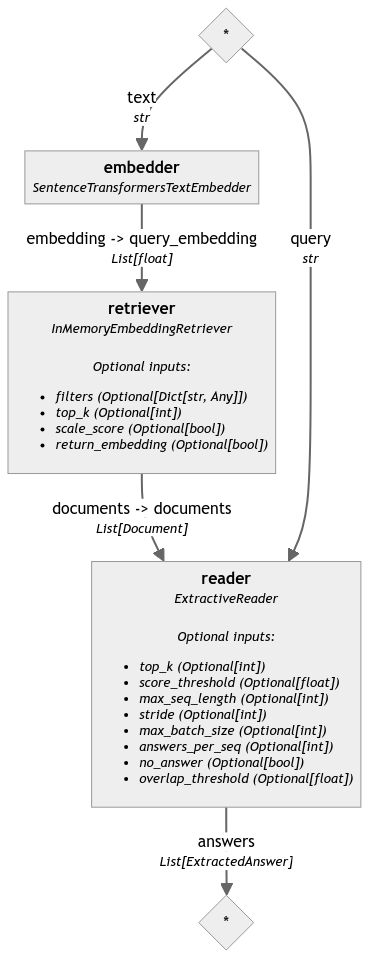

In [ ]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder


retriever = InMemoryEmbeddingRetriever(document_store=document_store)
reader = ExtractiveReader(model='deepset/roberta-base-squad2')
reader.warm_up()

extractive_qa_pipeline = Pipeline()

extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")

In [ ]:
for doc in documents:
  print (doc)

Document(id=088eaa6a1fa1b155d6cad3c995d44cb84506e1662dd0d24a2c674eb3c47c46f3, content: 'Title: Joyland
Description: Welcome to 1984 and the town of South Wakefield. Chris Lane is 14 and he...', meta: {'title': 'Joyland', 'authors': 'Emily Schultz', 'publisher': 'ECW Press', 'publishedDate': '2006-04', 'industryIdentifiers': "{'type': 'ISBN_13', 'identifier': '9781554902651'}, {'type': 'ISBN_10', 'identifier': '1554902657'}", 'readingModes': {'text': True, 'image': True}, 'pageCount': 301, 'printType': 'BOOK', 'categories': 'Fiction', 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': True, 'contentVersion': '0.5.4.0.preview.3', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=A_d0uAikdR4C&printsec=frontcover&img=1&zoom=5&edge=curl&source=gbs_api', 'thumbnail': 'http://books.google.com/books/content?id=A_d0uAikdR4C&printsec=frontcover&img=1&zoom=1&edge=curl&source=gbs_api'}, 

Try extracting some answers.

In [ ]:
query = "what is Beautiful Ruins about?"
extractive_qa_pipeline.run(
    data={"embedder": {"text": query}, "retriever": {"top_k": 3}, "reader": {"query": query, "top_k": 1}}
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'reader': {'answers': [ExtractedAnswer(query='what is Beautiful Ruins about?', score=0.727833092212677, data='a story of flawed yet fascinating people', document=Document(id=b9d4a6dcf787c53f5a1e911b665be9c947d7b6333a88b978d1ac828fd3efa9dd, content: 'Title: Beautiful Ruins
   Description: In 1962, on a rocky patch of sun-drenched Italian coastline, a y...', meta: {'title': 'Beautiful Ruins', 'authors': 'Jess Walter', 'publisher': 'Center Point', 'publishedDate': '2012', 'industryIdentifiers': "{'type': 'ISBN_10', 'identifier': '161173536X'}, {'type': 'ISBN_13', 'identifier': '9781611735369'}", 'readingModes': {'text': False, 'image': False}, 'pageCount': 0, 'printType': 'BOOK', 'categories': 'Actors and actresses', 'maturityRating': 'NOT_MATURE', 'allowAnonLogging': False, 'contentVersion': 'preview-1.0.0', 'panelizationSummary': {'containsEpubBubbles': False, 'containsImageBubbles': False}, 'imageLinks': {'smallThumbnail': 'http://books.google.com/books/content?id=Eu0uMAEACAAJ&printse

In [ ]:
pip install chroma-haystack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.0/506.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.0

## `ExtractiveReader`: a closer look

Here's an example answer:
```python
[ExtractedAnswer(query='Who was Pliny the Elder?', score=0.8306006193161011, data='Roman writer', document=Document(id=bb2c5f3d2e2e2bf28d599c7b686ab47ba10fbc13c07279e612d8632af81e5d71, content: 'The Roman writer Pliny the Elder, writing in the first century AD, argued that the Great Pyramid had...', meta: {'url': 'https://en.wikipedia.org/wiki/Great_Pyramid_of_Giza', '_split_id': 16}
```

The confidence score ranges from 0 to 1. Higher scores mean the model has more confidence in the answer's relevance.

The Reader sorts the answers based on their probability scores, with higher probability listed first. You can limit the number of answers the Reader returns in the optional `top_k` parameter.

By default, the Reader sets a `no_answer=True` parameter. This param returns an `ExtractedAnswer` with no text, and the probability that none of the returned answers are correct.

```python
ExtractedAnswer(query='Who was Pliny the Elder?', score=0.04606167031102615, data=None, document=None, context=None, document_offset=None, context_offset=None, meta={})]}}
```

`.0.04606167031102615` means the model is fairly confident the provided answers are correct in this case. You can disable this behavio and return only answers by setting the `no_answer` param to `False` when initializing your `ExtractiveReader`.


## Wrapping it up

If you've been following along, now you know how to build an extractive question answering pipeline with Haystack 2.0. 🎉 Thanks for reading!


If you liked this tutorial, there's more to learn about Haystack 2.0:
- [Classifying Documents & Queries by Language](https://haystack.deepset.ai/tutorials/32_classifying_documents_and_queries_by_language)
-  [Generating Structured Output with Loop-Based Auto-Correction](https://haystack.deepset.ai/tutorials/28_structured_output_with_loop)
- [Preprocessing Different File Types](https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline)

To stay up to date on the latest Haystack developments, you can [sign up for our newsletter](https://landing.deepset.ai/haystack-community-updates?utm_campaign=developer-relations&utm_source=extractive_qa_tutorial).